Placenta height: 3.181642481356553
Sphere radius: 14.518876558339993
placentone_removal_sphere_radius: 30.461511238292196
placentone_removal_height: 1.8
cotyledon_wall_heights: [1.85371109,2.58840669,1.74967258,2.23301244,1.93398253,2.38461487]
lobule_wall_heights: [0.92685555,1.29420334,0.87483629,1.11650622,0.96699126,1.19230744]
Voronoi generating points : 
 [[ 6.6801457   1.1839978 ]
 [ 2.248453   -4.7815226 ]
 [-0.41532437  0.81617302]
 [ 1.2449482   6.0864235 ]
 [-5.4186901   3.7657733 ]
 [-4.6876481  -4.1060797 ]]


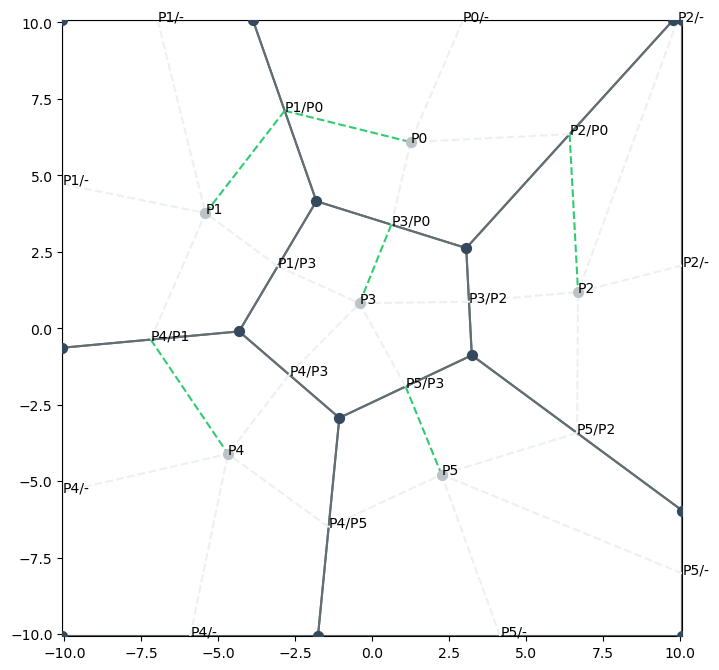

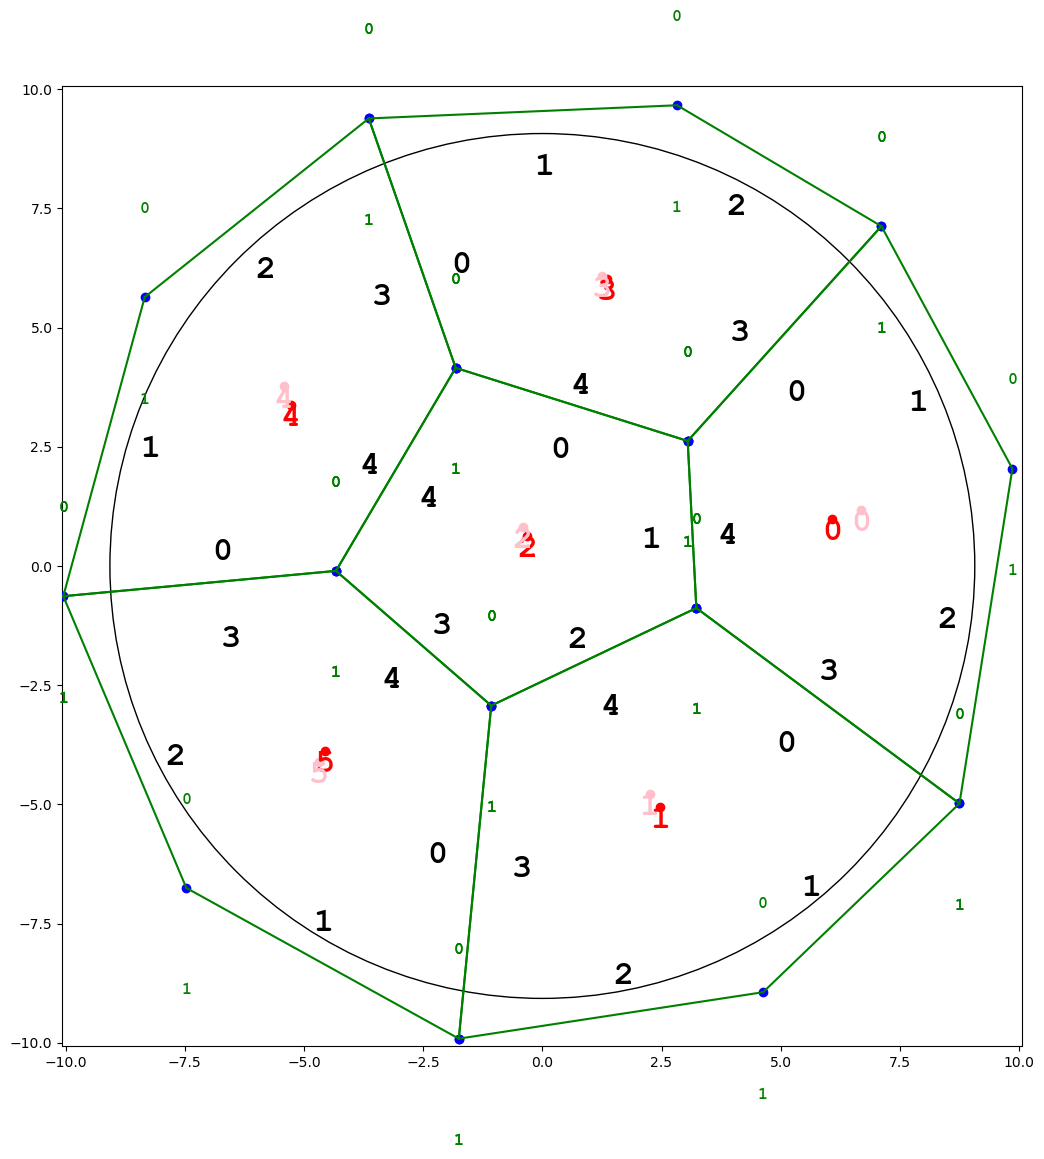

Total number of 3D elements: 0
Total number of 3D elements: 5794


SystemExit: -1

In [ ]:
import os
import sys
import importlib
import pathlib

import math
import scipy
import numpy
import copy
import time

import gmsh
import matplotlib
import foronoi

import placenta_const
import placenta_plots as plots
import placenta_fns as fns
import placenta_classes as clses
import placenta_foronoi as frni
import placenta_shape as shape
import placenta_vessels as vessels
import placenta_regions as regions
import placenta_fields as fields
import store_mesh as store

importlib.reload(placenta_const)
importlib.reload(plots)
importlib.reload(fns)
importlib.reload(clses)
importlib.reload(frni)
importlib.reload(shape)
importlib.reload(vessels)
importlib.reload(regions)
importlib.reload(fields)
importlib.reload(store)

from placenta_const import *

# Initialise GMSH
gmsh.initialize()
gmsh = set_gmsh_optns(gmsh)
model = gmsh.model

########################### INITIALISE QUANTITIES ##########################
# Set up a bounding box object and storage
bounding_box = clses.BoundingBox()
#bounding_boxes = []

# Set up a face object and list storage
face = clses.Face()
#inlet_faces = []
outlet_faces = []
surf_COMs_to_ignore = []
field_list = []
no_inlets = 0
no_outlets = 0 # First basal, then peripheral, then septal wall
no_lobule_veins = 0
####################### END OF INITIALISE QUANTITIES #######################

###################### REMOVAL OBJECTS #######################
# Debug box, whole domain
#Box(1000) = {-BasalPlateSphereRadius*2,-BasalPlateSphereRadius*2,-BasalPlateSphereRadius*2,
#                BasalPlateSphereRadius*4,BasalPlateSphereRadius*4,BasalPlateSphereRadius*4}

# Box that cuts off initial sphere past placenta_height
model.occ.addBox(-initial_sphere_radius,-initial_sphere_radius,initial_sphere_radius*2, \
                initial_sphere_radius*2,initial_sphere_radius*2,-initial_sphere_radius*2+placenta_height, \
                1000)
# Cylinder for straight top part
#model.occ.addCylinder(0.0,0.0,placenta_height, \
#                        0.0,0.0,top_cyl_height, \
#                        placenta_radius,1001)

###################### END OF REMOVAL OBJECTS #######################

print(f"Placenta height: {placenta_height}")
print(f"Sphere radius: {initial_sphere_radius}")
print(f"placentone_removal_sphere_radius: {removal_sphere_radius(placentone_removal_height)}")
print(f"placentone_removal_height: {placentone_removal_height}")
print(f"cotyledon_wall_heights: {numpy.array2string(cotyledon_wall_heights, separator=',')}")
print(f"lobule_wall_heights: {numpy.array2string(lobule_wall_heights, separator=',')}")

#Sphere(1) = {0.0,0.0,initial_sphere_radius,initial_sphere_radius}
model.occ.addSphere(*initial_sphere_centre,initial_sphere_radius,1)

# model.occ.cut([(3,1)], [(3,1000)], tag=2, removeObject=True, removeTool=True)  - omitting tag=.. means that the smallest tag no. that is deleted is taken
# Putting tag=lowest_tag_no gives error
model.occ.cut([(3,1)], [(3,1000)])
#model.occ.fuse([(3,1)], [(3,1001)])


'''
# Debug
field_no = 100
model.mesh.field.add("Constant",field_no)
model.mesh.field.setNumber(field_no,"IncludeBoundary",1)
model.mesh.field.setNumber(field_no,"VIn",DomSize/2.0)
model.mesh.field.setNumber(field_no,"VOut",DomSize/2.0)
model.mesh.field.setNumbers(field_no,"VolumesList",[1,2,3,4,5,6,7,8,9,10])
field_list = field_list + [field_no]
model.mesh.field.setAsBackgroundMesh(100)
'''


points = shape.setup_voronoi_pts()
v = shape.setup_voronoi_diagram(points)

model.occ.synchronize()

[cotyledon_node_set,cotyledon_edge_set,cotyledons] = \
    shape.create_cotyledons(model,points,no_placentones,v)

# Debug output
#plots.plot_edge_set(cotyledon_edge_set,cotyledons)
#cotyledon_node_set.print_members()

model.occ.synchronize()


# # -------------- DEL
# field_list = []

# field_no = 100
# model.mesh.field.add("Constant",field_no)
# model.mesh.field.setNumber(field_no,"IncludeBoundary",1)
# model.mesh.field.setNumber(field_no,"VIn",DomSize)
# model.mesh.field.setNumber(field_no,"VOut",DomSize)
# model.mesh.field.setNumbers(field_no,"VolumesList",[1])
# field_list = field_list + [field_no]

# [model,field_list] = fields.refine_cot_walls(model,cotyledon_edge_set,field_list)

# model.mesh.field.add("Min",900)
# model.mesh.field.setNumbers(900,"FieldsList",field_list)
# model.mesh.field.setAsBackgroundMesh(900)

# model.occ.synchronize()
# gmsh.fltk.run()
# sys.exit(-2)
# -----------------


[lobule_node_set,lobule_edge_set,no_lobules,lobules, \
        lobule_node_set_per_cotyledon,lobule_edge_set_per_cotyledon] = \
    shape.create_lobules(model,no_placentones,cotyledons, \
    cotyledon_node_set,cotyledon_edge_set)
        
# plots.plot_edge_set(lobule_edge_set_per_cotyledon[i],plot_node_set=True)
# lobule_edge_set_per_cotyledon[i].print_members()

# model.occ.synchronize()
# c_a_n = [2,2,1,1,4,1]
# c_v_n = [7,7,5,8,9,4]
# plots.plot_cotyeldon_lobule_list(points, cotyledons, lobules, c_a_n, c_v_n)

[no_inlets,no_cavities,bounding_boxes,inlet_faces,cavities,no_lobule_veins,no_outlets,outlet_faces] = \
        vessels.add_spiral_arteries_and_lobule_veins(model,no_lobules, \
            cotyledons,lobules,no_inlets,no_lobule_veins,no_outlets,outlet_faces)

model.occ.synchronize()
 
[model,no_marginal_sinus_veins_added,no_outlets,outlet_faces] = \
    vessels.create_marginal_veins(model,cotyledons,lobules,no_outlets,outlet_faces)

model.occ.synchronize()

[no_septal_wall_veins,no_outlets,outlet_faces] = \
    vessels.create_septal_veins(model,no_placentones,cotyledons, \
        cotyledon_edge_set,no_outlets,outlet_faces,lobule_node_set_per_cotyledon)

model.occ.synchronize()
# gmsh.fltk.run()


##################################################################
###################### SEPTAL WALL VEINS #########################
##################################################################

model.occ.synchronize()
#gmsh.fltk.run()


  
start = time.time()
regions.create_ellipsoid_cavities(model,cavities)
end = time.time()
print(f"Time to compute ellipsoid cavities: {end-start}")

print(f"Creating septal fragments")

'''
model.occ.synchronize()
gmsh.fltk.run()
gmsh.finalize()
sys.exit(-2)
'''

start = time.time()
[model,surf_COMs_to_ignore] = regions.create_septal_fragment(model,outlet_faces,surf_COMs_to_ignore)
end = time.time()
print(f"Time to compute septal fragments: {end-start}")

print(f"Finished septal fragments")

model.occ.synchronize()

print(f"Adding nodes to inlet surfaces")
    
surface_label_pairs = model.occ.getEntities(dim=2)

no_surfs = len(surface_label_pairs)
surface_centres = numpy.zeros((3,no_surfs))

for pair_no in range(0,no_surfs):
    surf_pair = surface_label_pairs[pair_no]
    surf_no = surf_pair[1]
    surface_centres[:,pair_no] = model.occ.getCenterOfMass(2,surf_no)
    
for inlet_face_no in range(0,no_inlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        inlet_faces[inlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            inlet_faces[inlet_face_no].face_no = surf_no
            
            ##################### ADD NODES TO INLET CENTRES #####################   
            embed_pt_no = model.occ.addPoint(*inlet_faces[inlet_face_no].centre,1.0)
            model.occ.synchronize()
            model.mesh.embed(0, [embed_pt_no], 2, surf_no)
            model.occ.synchronize()
            ##################### ADD NODES TO INLET CENTRES #####################   
            
            print("inlet_face_no ",inlet_face_no," corresponds to surface ",surf_no)
            break
        
        
for outlet_face_no in range(0,no_outlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        outlet_faces[outlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            outlet_faces[outlet_face_no].face_no = surf_no
            
            ##################### ADD NODES TO OULET CENTRES #####################   
            embed_pt_no = model.occ.addPoint(*outlet_faces[outlet_face_no].centre,1.0)
            model.occ.synchronize()
            model.mesh.embed(0, [embed_pt_no], 2, surf_no)
            model.occ.synchronize()
            ##################### ADD NODES TO OUITLET CENTRES #####################   
            
            print("outlet_face_no ",outlet_face_no," corresponds to surface ",surf_no)
            break    
     




    
######################## PHYSICAL GROUP SETUP ########################

# Need a sync before adding physical groups, otherwise they aren't properly set up
# and lower-dimensional, non-physical-grouped entities are saved
model.occ.synchronize()

# Set up quantities
no_inlets_outlets = no_inlets+no_outlets
print("no_inlets_outlets: ",no_inlets_outlets)

surface_label_pairs = model.occ.getEntities(dim=2)
surface_label_pairs_no_slip = copy.deepcopy(surface_label_pairs)

no_surfs = len(surface_label_pairs)
surface_centres = numpy.zeros((3,no_surfs))
for pair_no in range(0,no_surfs):
    surf_pair = surface_label_pairs[pair_no]
    surf_no = surf_pair[1]
    surface_centres[:,pair_no] = model.occ.getCenterOfMass(2,surf_no)

for outlet_face_no in range(0,no_outlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        outlet_faces[outlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            outlet_faces[outlet_face_no].face_no = surf_no
            
            apto_bdry_no = 101+outlet_face_no
            outlet_faces[outlet_face_no].update_apto_bdry_no(apto_bdry_no)
            model.addPhysicalGroup(2, [surf_no], apto_bdry_no, "Outlet "+str(outlet_face_no))
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("outlet_face_no ",outlet_face_no," corresponds to surface ",surf_no)
            break
            
for inlet_face_no in range(0,no_inlets):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        inlet_faces[inlet_face_no].centre[:]-surface_centres[:,pair_no] \
                                   )
        if (sq_dist < tol):
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]
            inlet_faces[inlet_face_no].face_no = surf_no 
            
            apto_bdry_no = 2+inlet_face_no
            inlet_faces[inlet_face_no].update_apto_bdry_no(apto_bdry_no)
            model.addPhysicalGroup(2, [surf_no], apto_bdry_no, "Inlet "+str(inlet_face_no))
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("inlet_face_no ",inlet_face_no," corresponds to surface ",surf_no)
            break


for cavity_no in range(0, no_cavities):
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        cavities[cavity_no].COM[:]-surface_centres[:,pair_no] \
                                   )
        
        if (sq_dist < large_geom_tol):               
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]   
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("cavity ghost surface ",cavity_no," corresponds to surface ",surf_no)
            
for surf_COM in surf_COMs_to_ignore:
    for pair_no in range(0,no_surfs):
        sq_dist = numpy.linalg.norm( \
                        surf_COM[:]-surface_centres[:,pair_no] \
                                   )
        
        if (sq_dist < large_geom_tol):               
            surf_pair = surface_label_pairs[pair_no]
            surf_no = surf_pair[1]   
            
            surface_label_pairs_no_slip[pair_no] = (-1,-1)
            print("outlet plane ghost surface ",surf_COM," corresponds to surface ",surf_no)

        
surface_label_pairs_no_slip[:] = [value for value in surface_label_pairs_no_slip if value != (-1,-1)]
no_no_slip_surfs = len(surface_label_pairs_no_slip)
surface_nos_no_slip = [value[1] for value in surface_label_pairs_no_slip]




model.addPhysicalGroup(2, surface_nos_no_slip, 1, "No slip")





model.addPhysicalGroup(3, [pair[1] for pair in model.occ.getEntities(3)], 1, "Domain")


# Set the baseline, coarse mesh size
field_list = []

field_no = 100
model.mesh.field.add("Constant",field_no)
model.mesh.field.setNumber(field_no,"IncludeBoundary",1)
model.mesh.field.setNumber(field_no,"VIn",DomSize)
model.mesh.field.setNumber(field_no,"VOut",DomSize)
model.mesh.field.setNumbers(field_no,"VolumesList",[1])
field_list = field_list + [field_no]

for inlet_no in range(0,no_inlets):
    field_no = 201+inlet_no
    start_pt = numpy.copy(inlet_faces[inlet_no].centre)
    normal = numpy.copy(inlet_faces[inlet_no].outward_unit_normal)
    start_pt = start_pt + mesh_offset_length*normal
    
    x_diff = -1.25*septal_vessel_length*normal[0]
    y_diff = -1.25*septal_vessel_length*normal[1]
    z_diff = -1.25*septal_vessel_length*normal[2]
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",IOSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",septal_artery_radius*1.75)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
    
    field_list = field_list + [field_no]
    
# Lobuile veins eins
for outlet_no in range(0,no_lobule_veins):

    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)
    length = outlet_faces[outlet_no].cylinder_length

    end_pt = start_pt - length*normal
    field_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",BasalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",1.5*field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",field_radius/2.0)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
        
    field_list = field_list + [field_no]
    
    x_diff = -1.1*length*normal[0]
    y_diff = -1.1*length*normal[1]
    z_diff = -1.1*length*normal[2]
    
    # Add vein pipe mesh size
    field_no = 1301+outlet_no
    
    total_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",BasalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",total_radius*1.1)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
        
    field_list = field_list + [field_no]
    
# Marginal sinus veins
for outlet_no in range(no_lobule_veins,no_lobule_veins+no_marginal_sinus_veins_added):

    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)
    length = outlet_faces[outlet_no].cylinder_length

    end_pt = start_pt - length*normal
    field_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",MarginalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",1.5*field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",field_radius/2.0)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
        
    field_list = field_list + [field_no]
    
    x_diff = -1.1*length*normal[0]
    y_diff = -1.1*length*normal[1]
    z_diff = -1.1*length*normal[2]
    
    # Add vein pipe mesh size
    field_no = 1301+outlet_no
    
    total_radius = outlet_faces[outlet_no].cylinder_radius+outlet_faces[outlet_no].cylinder_fillet
    
    model.mesh.field.add("Cylinder",field_no)
    model.mesh.field.setNumber(field_no,"VIn",MarginalSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",total_radius*1.1)
    model.mesh.field.setNumber(field_no,"XCenter",start_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",start_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",start_pt[2])
    model.mesh.field.setNumber(field_no,"XAxis",x_diff)
    model.mesh.field.setNumber(field_no,"YAxis",y_diff)
    model.mesh.field.setNumber(field_no,"ZAxis",z_diff)
        
    field_list = field_list + [field_no]
    
# Other veins (e.g. septal walls)
for outlet_no in range(no_lobule_veins+no_marginal_sinus_veins_added,no_outlets):
    
    field_no = 301+outlet_no
    start_pt = numpy.copy(outlet_faces[outlet_no].centre)
    normal = numpy.copy(outlet_faces[outlet_no].outward_unit_normal)

    end_pt = start_pt - 1.5*vein_length*normal
    field_radius = numpy.linalg.norm(end_pt-start_pt)+mesh_offset_length
    
    model.mesh.field.add("Ball",field_no)
    model.mesh.field.setNumber(field_no,"VIn",VeinSize)
    model.mesh.field.setNumber(field_no,"VOut",DomSize)
    model.mesh.field.setNumber(field_no,"Radius",field_radius)
    model.mesh.field.setNumber(field_no,"Thickness",2.0*placentone_wall_thickness)
    model.mesh.field.setNumber(field_no,"XCenter",end_pt[0])
    model.mesh.field.setNumber(field_no,"YCenter",end_pt[1])
    model.mesh.field.setNumber(field_no,"ZCenter",end_pt[2])
    
    field_list = field_list + [field_no]

[model,field_list] = fields.refine_inside_around_cavity(model,no_cavities,cavities,field_list)
    
[model,field_list] = fields.refine_apex_cavity(model,no_cavities,cavities,field_list)

[model,field_list] = fields.refine_cot_walls(model,cotyledon_edge_set,field_list)

# Calculate the min of all
model.mesh.field.add("Min",900)
model.mesh.field.setNumbers(900,"FieldsList",field_list)

# Set the min field as the mesh size function
model.mesh.field.setAsBackgroundMesh(900)

######################################################
# ---------------------- Save ---------------------- #
######################################################

mesh_prefix = f"{placenta_id}_s{no_septal_wall_veins}p{no_marginal_sinus_veins_added}b{no_lobule_veins}a{no_inlets}"
[meshID,meshIDX,mesh_eles] = store.store_mesh(gmsh,mesh_prefix)

if (mesh_eles < 1):
    print("Failed meshing")
    gmsh.finalize()
    sys.exit(-1)

geom_info_header = "placenta_radius,placenta_volume," \
        +"initial_sphere_radius,initial_sphere_centre_x,initial_sphere_centre_y,initial_sphere_centre_z," \
        +"septal_artery_radius,septal_vein_radius,marginal_sinus_vein_radius," \
        +"no_basal_plate_veins,no_peripheral_veins,no_septal_wall_veins,no_arteries,avg_c_wall_height\n"
geom_info_str = f"{placenta_radius},{placenta_volume},{initial_sphere_radius}," \
        +f"{initial_sphere_centre[0]},{initial_sphere_centre[1]},{initial_sphere_centre[2]}," \
        +f"{septal_artery_radius},{septal_vein_radius},{marginal_sinus_vein_radius}," \
        +f"{no_lobule_veins},{no_marginal_sinus_veins_added},{no_outlets-no_lobule_veins-no_marginal_sinus_veins_added}," \
        +f"{no_inlets}," \
        +f"{cotyledon_node_set.calc_avg_rel_wall_height_within_cutoff(placenta_radius)}"
with open('all_geom_info.csv', 'a') as file:
    file.write(f"\n{store.read_idx()},{placenta_id},{geom_info_str}")
    file.close()
with open("geom_info.csv","w") as store_geom:
    store_geom.write(geom_info_header)
    store_geom.write(geom_info_str)
    store_geom.close()

with open("mesh_info.csv","w") as store_faces:
    store_faces.write("bdry_no,radius,centre_x,centre_y,centre_z,normal_x,normal_y,normal_z\n")
    for inlet_face_no in range(0,no_inlets):
        inlet_face = inlet_faces[inlet_face_no]
        face_centre = inlet_face.centre
        face_normal = inlet_face.outward_unit_normal
        store_faces.write("{bdry_no},{r},{c1},{c2},{c3},{n1},{n2},{n3}" \
                        .format(bdry_no=inlet_face.apto_bdry_no,r=septal_vein_radius, \
                                c1=face_centre[0],c2=face_centre[1],c3=face_centre[2], \
                                n1=face_normal[0],n2=face_normal[1],n3=face_normal[2]))
        if (inlet_face_no < no_inlets-1):
            store_faces.write("\n")
    store_faces.close()
    
with open("outlet_info.csv","w") as store_faces:
    store_faces.write("bdry_no,radius,outside_centre_x,outside_centre_y,outside_centre_z,normal_x,normal_y,normal_z,vein_length,fillet_radius\n")
    for outlet_face_no in range(0,no_outlets):
        outlet_face = outlet_faces[outlet_face_no]
        face_centre = outlet_face.centre
        face_normal = outlet_face.outward_unit_normal
        outlet_length = outlet_face.cylinder_length
        outlet_fillet = outlet_face.cylinder_fillet
        store_faces.write("{bdry_no},{r},{c1},{c2},{c3},{n1},{n2},{n3},{vl},{fr}" \
                        .format(bdry_no=outlet_face.apto_bdry_no,r=outlet_face.cylinder_radius, \
                                c1=face_centre[0],c2=face_centre[1],c3=face_centre[2], \
                                n1=face_normal[0],n2=face_normal[1],n3=face_normal[2], \
                                vl=outlet_length,fr=outlet_fillet))
        if (outlet_face_no < no_outlets-1):
            store_faces.write("\n")
    store_faces.close()

with open("cavity_info.csv","w") as store_cavities:
    store_cavities.write("cavity_no,minor_axis,major_axis,centre_x,centre_y,centre_z,orientation_normal_x,orientation_normal_y,orientation_normal_z\n")
    for cavity_no in range(0, no_cavities):
        centre = cavities[cavity_no].centre
        normal = cavities[cavity_no].orientation_normal
        minor_axis = cavities[cavity_no].minor_axis
        major_axis = cavities[cavity_no].major_axis
        store_cavities.write(f"{cavity_no+1},{minor_axis},{major_axis},"
            f"{centre[0]},{centre[1]},{centre[2]},{normal[0]},{normal[1]},{normal[2]}")
        if (cavity_no < no_cavities-1):
            store_cavities.write("\n")
    store_cavities.close()

with open("c_wall_info.csv","w") as wall_info:
    wall_info.write("node_no,rel_wall_height,type\n")
    for node_no in range(0,cotyledon_edge_set.node_set.no_nodes):
        if (circ_eval(*cotyledon_edge_set.node_set.node[node_no,0:2]) >= placenta_radius**2):
            loc = "ext"
        else:
            loc = "int"
        wall_info.write(f"{node_no}, \
            {cotyledon_edge_set.node_set.rel_wall_height[node_no]}, \
            {loc}")
        if (node_no < cotyledon_edge_set.node_set.no_nodes-1):
            wall_info.write("\n")
    wall_info.close()
    
# Writes cotyledon edge node locations - checks if cell_nodes is setup, then write to file
# Uses indexing from 1 for Fortran
if (cotyledon_node_set.cell_nodes is not None):
    with open("c_loc.csv","w") as c_loc:
        c_loc.write("c_no,c_node_no,node_x,node_y\n")
        no_cells = len(cotyledon_node_set.cell_nodes[:,0])
        for cell_no in range(0,no_cells):
            cell_nodes_to_write = numpy.zeros((cotyledon_node_set.no_cell_nodes[cell_no],2))
            no_cell_nodes = cotyledon_node_set.no_cell_nodes[cell_no]
            cell_edge_done = numpy.zeros(no_cell_nodes, dtype=int)
            
            start_v = None
            end_v = None
            vertices = cotyledon_edge_set.get_vertices_from_cell_edge(cell_no,0)
            start_v = copy.deepcopy(vertices[0])
            end_v = copy.deepcopy(vertices[1])
            cell_edge_done[0] = 1
            cell_nodes_to_write[0,:] = start_v
            # c_loc.write(f"{cell_no + 1},1,{start_v[0]},{start_v[1]}\n")
            
            # The point of new_node_no is to create new local numbering s.t. 1 -> 2 -> 3 -> 4 -> ...
            cell_edge_no = 0
            new_node_no = 1
            while (numpy.sum(cell_edge_done) < no_cell_nodes and cell_edge_no < no_cell_nodes):
                cell_edge_no = cell_edge_no + 1
                if (cell_edge_done[cell_edge_no] == 0):
                    vertices = \
                        cotyledon_edge_set.get_vertices_from_cell_edge(cell_no,cell_edge_no)
                    
                    p1_near = fns.points_near(vertices[0],end_v)
                    p2_near = fns.points_near(vertices[1],end_v)
                    if (p1_near or p2_near):
                        if (p1_near):
                            start_v = copy.deepcopy(vertices[0])
                            end_v = copy.deepcopy(vertices[1])
                        else:
                            start_v = copy.deepcopy(vertices[1])
                            end_v = copy.deepcopy(vertices[0])
                        cell_nodes_to_write[new_node_no,:] = start_v
                        # c_loc.write(f"{cell_no + 1},{new_node_no + 1},{start_v[0]},{start_v[1]}")
                        cell_edge_done[cell_edge_no] = 1
                        cell_edge_no = 0
                        new_node_no = new_node_no + 1
                    elif (cell_edge_no == no_cell_nodes-1):
                        print(f"Error: cotyledon cell {cell_no} has no connected edges")
                        break
                    else:
                        continue
            cell_nodes_to_write = fns.check_orientation_of_polygon(cell_nodes_to_write)
            for cell_edge_no in range(0,no_cell_nodes):
                c_loc.write(f"{cell_no + 1},{cell_edge_no + 1},{cell_nodes_to_write[cell_edge_no,0]},{cell_nodes_to_write[cell_edge_no,1]}")
                # Create newline if not on last line
                if (cell_no != no_cells - 1 or \
                        cell_edge_no != cotyledon_node_set.no_cell_nodes[cell_no] - 1):
                    c_loc.write(f"\n")
        c_loc.close()

# Launch the GUI to see the results:
if (open_gmsh):
    if '-nopopup' not in sys.argv:
        gmsh.fltk.run()
    
gmsh.finalize()

In [ ]:
# REMEMBER THAT FORONOI/POLYGON.PY _get_intersection_.. NEED TO BE CHANGED TO
'''
    def _get_intersection_point(self, orig, end):
        p = self.points + [self.points[0]]
        points = []

        point = None

        for i in range(0, len(p) - 1):
            intersection_point = Algebra.get_intersection(orig, end, p[i], p[i + 1])
            if intersection_point:
                points.append(intersection_point)

        if len(points) == 0:
            point = None
        elif len(points) == 1:  # this is the actual change
            point = points[0]
        else:
            max_distance = Algebra.distance(orig, end)

            # Find the intersection point that is furthest away from the start
            if points:
                distances = [Algebra.distance(orig, p) for p in points]
                distances = [i for i in distances if i <= max_distance]
                if distances:
                    point = points[np.argmax(distances)]

        return point
'''
# Otherwise can randomly get empty cell

# Ideas that haven't worked out / save for future



'''
# Set the no-slip boundary on the assumption that the inlet, outlet boudaries are at the end of model.occ.getEntities(dim=2)
# If this ends up not being the case, another approach is to store the inlet, outlet GMSH labels, loop through model.occ.getEntities(dim=2)
# for boundary labels which don't belong to inlet, outlet and set that to 0
surface_label_pairs = model.occ.getEntities(dim=2)
no_surface_label_pairs = len(surface_label_pairs)
no_noslip_surfaces = no_surface_label_pairs-no_inlets_outlets
noslip_labels = [pair[1] for pair in surface_label_pairs[0:no_noslip_surfaces]]
#model.addPhysicalGroup(2, noslip_labels, 1, "Noslip")
#print("no slip boundary labels: ",noslip_labels)

start_inlet_no = model.occ.getMaxTag(2)-no_inlets_outlets+1
print("start_inlet_no: ",start_inlet_no)
#for inlet_no in range(0,no_inlets):
#    model.addPhysicalGroup(2, [start_inlet_no+inlet_no], 2+inlet_no, "Inlet")
    #print("adding surface no ",start_inlet_no+inlet_no," as inlet with bdry_no ",2+inlet_no)

start_outlet_no = model.occ.getMaxTag(2)-no_outlets+1
print("start_outlet_no: ",start_outlet_no)
#for outlet_no in range(0,no_outlets):
#    model.addPhysicalGroup(2, [start_outlet_no+outlet_no], 101+outlet_no, "Outlet")
    #print("adding surface no ",start_outlet_no+outlet_no," as outlet with bdry_no ",2+outlet_no)
'''







'''
# IsInside doesn't work properly if there isn't a node on the surface, presume related to https://gitlab.onelab.info/gmsh/gmsh/-/issues/1246
surfs = model.occ.getEntities(dim=2)
no_surfs = len(surfs)
print(surfs)
for i in range(0,no_surfs):
    inside = False
    print("i = ",i)
    pair = surfs[i]
    inside = model.isInside(2,pair[1],TEST_vein_pt)
    if (inside):
        print("INSIDE: ",pair[1])
'''



""" TEST """
#model.occ.fuse([(3,1)],[(1,2)])

#def removeEmbedded(dimTags, dim=-1):
#def getEmbedded(dim, tag):
#def removeDuplicateNodes(dimTags=[])
#def removeDuplicateElements(dimTags=[])
#def remove(tag)
#def list():

#model.occ.removeAllDuplicates()    
#model.occ.healShapes()    
    
#model.occ.addPoint(0.0,0.0,100.0,DomSize,curr_pt)
#model.occ.remove([(0,curr_pt)], recursive=False)
#print(model.mesh.getEmbedded(3, 1))
#model.mesh.removeEmbedded([(80)], dim=-1)    
 
    
"""    
fig = matplotlib.pyplot.figure(figsize=(10,10))
axis = matplotlib.pyplot.axes()
axis.set_xlim(-placenta_radius,placenta_radius)
axis.set_ylim(-placenta_radius,placenta_radius)

matplotlib.pyplot.plot(frni_placentone.centroid[0],frni_placentone.centroid[1],'bo')
for vertex_no in range(0,frni_placentone.no_vertices):
    matplotlib.pyplot.plot(frni_placentone.vertices[0,vertex_no],frni_placentone.vertices[1,vertex_no],'go')
    matplotlib.pyplot.plot(frni_placentone_shrunk.vertices[0,vertex_no],frni_placentone_shrunk.vertices[1,vertex_no],'ro')

matplotlib.pyplot.show()
"""